In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ARDRegression

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import gplearn as gpl        
from gplearn.genetic import SymbolicRegressor

In [2]:
#Import and visualize the dataset
data = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2019-08-12.csv')

In [3]:
data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3997692,1565567760,11555.57,11555.57,11540.37,11540.58,0.036868,425.909106,11552.336234
3997693,1565567820,11553.49,11556.22,11553.49,11556.22,0.623462,7204.428272,11555.520505
3997694,1565567880,11559.73,11561.22,11546.77,11561.22,0.159070,1838.731403,11559.252199
3997695,1565567940,11559.73,11589.73,11528.73,11528.73,16.198210,187504.635170,11575.638889


In [4]:
#Get an idea of what parameters are correlated most with open price (which is what we want to predict)
data.corr()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,1.000000,0.727978,0.727783,0.728220,0.727981,-0.086029,0.219983,0.727997
Open,0.727978,1.000000,0.999999,0.999998,0.999998,-0.039713,0.361751,0.999999
High,0.727783,0.999999,1.000000,0.999997,0.999998,-0.039494,0.362273,0.999999
Low,0.728220,0.999998,0.999997,1.000000,0.999998,-0.039980,0.361131,0.999999
Close,0.727981,0.999998,0.999998,0.999998,1.000000,-0.039745,0.361676,0.999999
Volume_(BTC),-0.086029,-0.039713,-0.039494,-0.039980,-0.039745,1.000000,0.395642,-0.039752
Volume_(Currency),0.219983,0.361751,0.362273,0.361131,0.361676,0.395642,1.000000,0.361667
Weighted_Price,0.727997,0.999999,0.999999,0.999999,0.999999,-0.039752,0.361667,1.000000


In [5]:
#Get the raw time data from the dataframe
times = data['Timestamp']
numTimes = len(times)

Text(0, 0.5, 'Open price (USD)')

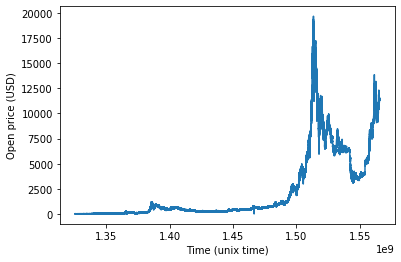

In [6]:
#Get an idea of the BTC price as a function of time
plt.plot(data['Timestamp'],data['Close'])
plt.xlabel('Time (unix time)')
plt.ylabel('Open price (USD)')

In [7]:
#Convert the dataframe to a format we can actually use
real_data = data.T.values

In [8]:
#Remove rows that have NaN's in them 
trimmed_data = []
nanCount = 0
for i in range(numTimes):
    if(np.isnan(real_data[1][i])):
        nanCount = nanCount + 1
    else:
        trimmed_data.append(real_data.T[i])

trimmed_data = np.array(trimmed_data)
print(nanCount)

1231878


In [9]:
#Chop up entire dataset into training and test data, and get the lengths of both
numUsedTimes = len(trimmed_data)
train_data = trimmed_data[:int(9*numUsedTimes/10)]
test_data = trimmed_data[int(9*numUsedTimes/10):]

N_train = len(train_data)
N_test = len(test_data)

In [10]:
def getXY(params, window_size):
    '''Convert the raw training and testing data into matrices X, Y, and X_test. X is obtained by looking at the 
    data window_size time steps into the past, and collecting the training data at every index specified in params.
    X_test is done very similarly with the test data, and Y is just the open price for each timestep.'''
    
    numParams = len(params)
    X = np.zeros(shape=(N_train - window_size, numParams*window_size))
    Y = np.zeros(N_train - window_size)
    for i in range(N_train-window_size):
        for j in range(numParams):
            X[i][window_size*j:window_size*(j+1)] = train_data.T[params[j]][i:i+window_size]
        Y[i] = train_data[i+window_size][1]
    
    X_test = np.zeros(shape=(N_test - window_size, numParams*window_size))
    for i in range(N_test-window_size):
        for j in range(numParams):
            X_test[i][window_size*j:window_size*(j+1)] = test_data.T[params[j]][i:i+window_size]
    
    return X, Y, X_test

In [11]:
def getPredictions(X, Y, X_test, fitted_model, window_size,modelType='sklearn'):
    '''Use the fitted_model to make predictions using X for the training set and X_test for the testing set. Note that
    we have to get the predictions differently if we are using a neural net vs. an sklearn fit.'''
    
    y_pred_train = np.zeros(N_train)
    y_pred_test = np.zeros(N_test)
    for i in range(window_size):
        y_pred_train[i] = train_data[i][1]
        
    if(modelType == 'sklearn'):
        y_pred_train[window_size:] = fitted_model.predict(X)
        y_pred_test[:window_size] = fitted_model.predict(X[len(X)-window_size:])
        y_pred_test[window_size:] = fitted_model.predict(X_test)
    
    elif(modelType == 'pytorch'):
        y_pred_train[window_size:] = fitted_model(torch.tensor(X,dtype=torch.float32)).detach().numpy().flatten()
        y_pred_test[:window_size] = fitted_model(torch.tensor(X[len(X)-window_size:],dtype=torch.float32)).detach().numpy().flatten()
        y_pred_test[window_size:] = fitted_model(torch.tensor(X_test,dtype=torch.float32)).detach().numpy().flatten()

    return y_pred_train, y_pred_test 

In [12]:
def squared_error(y_pred,y_real):
    '''Standard squared error. Nothing to see here.'''
    
    return (y_pred-y_real)**2

In [137]:
def getErrors(model,X,Y,X_test,window_size,verbose=False,modelType='sklearn',
              n_epochs=100,y_r_train=[],y_r_test=[]):
    '''Compute the squared error of the model by fitting to the data, making predictions, and then computing the
    squared error loss.'''
    
    if(modelType =='sklearn'):
        fit = model.fit(X,Y)
    
    elif(modelType == 'pytorch'):
        fit = train_nn(model,n_epochs,1,X,Y)

        
    y_pred_train, y_pred_test = getPredictions(X, Y, X_test, fit, window_size, modelType=modelType)
    
    if(len(y_r_train)>0):
        y_pred_train = y_pred_train -y_r_train
        
    if(len(y_r_test)>0):
        y_pred_test = y_pred_test -y_r_test

    e_in = sum(squared_error(y_pred_train,train_data.T[1]))/N_train
    e_out = sum(squared_error(y_pred_test,test_data.T[1]))/N_test
    
    if(verbose==True):
        print(test_data.T[1],y_pred_test)
    
    try:
        if(verbose == True):
            print(fit.coef_)
    except:
        print('Nonlinear fit')
        
    return  e_in, e_out 

In [54]:
#Get a baseline for the prediction errors by just using the previous open price as a prediction for the next one
y_pred_train_0 = np.zeros(N_train)
y_pred_train_0[0] = train_data[0][4]
for i in range(1,N_train):
    y_pred_train_0[i] = train_data[i-1][4]

y_pred_test_0 = np.zeros(N_test)
y_pred_test_0[0] = test_data[0][4]
for i in range(1,N_test):
    y_pred_test_0[i] = test_data[i-1][4]

e_in_0 = sum(squared_error(y_pred_train_0,train_data.T[1]))/N_train
e_out_0 = sum(squared_error(y_pred_test_0,test_data.T[1]))/N_test
print(e_in_0,e_out_0) #baseline errors

15.343478194217901 19.909692928317785


In [15]:
#The first model we'll try is linear regression
linear_model = LinearRegression()

In [16]:
#Define a few different datasets, based on different parameter choices and window sizes. Note that I tried a few others
#as well, but these were the ones that performed the best
X, Y, X_test = getXY([0,1,2,3,4,5,6],1)
X_2, Y_2, X_test_2 = getXY([1,2,3,4,5,6],1)
X_3, Y_3, X_test_3 = getXY([0,1,2,3,4,5,6],2)
X_4, Y_4, X_test_4 = getXY([0,1,2,3,4,5,6],3)

In [17]:
#Compute the error rates of each model. Note that all errors here and below are in the form (e_in, e_out)
print(getErrors(linear_model,X,Y,X_test,1))
print(getErrors(linear_model,X_2,Y_2,X_test_2,1))
print(getErrors(linear_model,X_3,Y_3,X_test_3,2))
print(getErrors(linear_model,X_4,Y_4,X_test_4,3))

(12.96044633532434, 18.274036288104583)
(12.960908094451439, 18.27592744536153)
(12.904788744982097, 18.317776628808474)
(12.899067872485176, 18.315128544208754)


In [206]:
#Next, try some fits with a ridge regression model. These were always slightly worse than the linear fits, no matter
#how I varied alpha.
ridge_model = Ridge(alpha=1000000)
print(getErrors(ridge_model,X,Y,X_test,1))
print(getErrors(ridge_model,X_2,Y_2,X_test_2,1))
print(getErrors(ridge_model,X_3,Y_3,X_test_3,2))
print(getErrors(ridge_model,X_4,Y_4,X_test_4,3))

(12.96192590839802, 18.3161145192644)
(12.962387794733054, 18.318142169560755)
(12.906178017998142, 18.355703899600606)
(12.900463023247672, 18.353711716551196)


In [208]:
#Same thing with the lasso model. None of these fits were very good no matter how I varied alpha.
lasso_model = Lasso(alpha = .01)
print(getErrors(lasso_model,X,Y,X_test,1))
print(getErrors(lasso_model,X_2,Y_2,X_test_2,1))
print(getErrors(lasso_model,X_3,Y_3,X_test_3,2))
print(getErrors(lasso_model,X_4,Y_4,X_test_4,3))

(63.14126391837603, 111.73308039907207)
(63.148799341389186, 111.73888540246773)
(122.01398267222756, 219.137255120359)
(180.8877698351098, 328.5087326685095)


In [212]:
#I tried a few other types of models. This histogram gradient boosting regressor was interesting, although ultimately
#wasn't very effective, no matter how I tuned the hyperparameters.
hist_gradient_boost_model = HistGradientBoostingRegressor(learning_rate = 1,max_iter=1000)
print(getErrors(hist_gradient_boost_model,X,Y,X_test,1))
print(getErrors(hist_gradient_boost_model,X_2,Y_2,X_test_2,1))
print(getErrors(hist_gradient_boost_model,X_3,Y_3,X_test_3,2))
print(getErrors(hist_gradient_boost_model,X_4,Y_4,X_test_4,3))

(1409.380053527461, 114216.1761391779)
(1715.946453380439, 6418.491984906092)
(832.3254314237316, 48344.85711313347)
(634.8631672785721, 37195.68167855047)


In [218]:
#Tried out a random forest regressor as well. Also wasn't super effective, and took forever to run.
random_forest_model = RandomForestRegressor()
print(getErrors(random_forest_model,X,Y,X_test,1))

In [219]:
#A couple of other fits I tried that ended up crashing my kernel or my entire computer...

#Do not run!
#gaussian_process_model = GaussianProcessRegressor()
#print(getErrors(gaussian_process_model,X,Y,X_test,1))

#ard_model = ARDRegression()
#print(getErrors(ard_model,X,Y,X_test,1))

In [149]:
def train_nn(model,N_epochs,r,X,Y,eta=1e-1):
    '''
    Train the nn model for N_epochs using a ratio r of the training set.
    The rest will be used as validation data.
    '''
    optimizer = torch.optim.Adam(model.parameters(), lr=eta)
    loss_fn = torch.nn.MSELoss()
    n_max = int(r*len(X))
    for epoch in range(N_epochs):
        # Forward pass: Compute predicted y by passing x to the model
        Y_pred = model(torch.tensor(X[:n_max],dtype=torch.float32))
        # Compute and print loss
        loss = loss_fn(Y_pred, torch.tensor(np.transpose(np.matrix(Y[:n_max])),dtype=torch.float32))

        if(epoch%int(N_epochs/10) == 0):
            print('epoch: ', epoch,' loss: ', loss.item())
    
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()

        # perform a backward pass (backpropagation)
        loss.backward()
    
        # Update the parameters
        optimizer.step()
        
    return(model)

In [19]:
#Define a neural network to test
nn_model = nn.Sequential( 
    nn.Linear(6, 20),
    nn.ReLU(),
    nn.Linear(20,10),
    nn.ReLU(),
    nn.Linear(10,5),
    nn.ReLU(),
    nn.Linear(5,1)
)
print(nn_model)


Sequential(
  (0): Linear(in_features=6, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=5, bias=True)
  (5): ReLU()
  (6): Linear(in_features=5, out_features=1, bias=True)
)


In [238]:
#Run the neural network. Note that I used the _2 data here (without the timesteps) since I was getting better fits
#this way. So far, I wasn't getting anything great out of the neural net, although it has some potential and moving
#forward I think I'll continue to tinker with it. I also might use it on top of the linear fit I already have to try
#and extract additional improvements on the current predictions.
print(getErrors(nn_model,X_2,Y_2,X_test_2,1,modelType = 'pytorch',n_epochs=400))

epoch:  0  loss:  16637088.0
epoch:  40  loss:  389530.03125
epoch:  80  loss:  4304.99755859375
epoch:  120  loss:  214.20401000976562
epoch:  160  loss:  109.1042709350586
epoch:  200  loss:  86.4802474975586
epoch:  240  loss:  70.82490539550781
epoch:  280  loss:  59.43095016479492
epoch:  320  loss:  51.11249923706055
epoch:  360  loss:  45.00065612792969
(40.46977179006838, 83.3539087087517)


In [152]:
#Now, try learning the residuals of a linear model and the true predictions using a neural net
linear_model_2 = LinearRegression()
fit = linear_model_2.fit(X_2,Y_2)
y_pred_train, y_pred_test = getPredictions(X_2, Y_2, X_test_2, fit, 1,modelType='sklearn')
Y_r = y_pred_train[1:] -Y_2

In [153]:
fit_nn = train_nn(nn_model,100,1,X_2,Y_r,eta=.1)

epoch:  0  loss:  12.960774421691895
epoch:  10  loss:  12.963347434997559
epoch:  20  loss:  12.961282730102539
epoch:  30  loss:  12.960771560668945
epoch:  40  loss:  12.960783958435059
epoch:  50  loss:  12.960772514343262
epoch:  60  loss:  12.960771560668945
epoch:  70  loss:  12.960771560668945
epoch:  80  loss:  12.960768699645996
epoch:  90  loss:  12.960769653320312


In [154]:
#Compute the predicted residuals and then compute the squared loss
y_r_train, y_r_test = getPredictions(X_2, Y_r, X_test_2, fit_nn, 1,modelType='pytorch')

In [155]:
#This was a small improvement over the linear fit on some runs, although the neural net was having a hard time 
#learning different predictions at each data point for whatever reason (i.e., all predicted residuals were the same).
#I went back and checked and it's not an issue with my code, it's just what the neural net is actually learning.
print(getErrors(linear_model,X,Y,X_test,1,y_r_train=y_r_train, y_r_test=y_r_test))

(12.960454294142252, 18.274072173805777)


In [51]:
#Next, I worked with a symbolic regression model. This also produced decent results, although still was slightly 
#worse than the linear fit.
def _xexp( x ):
    a = np.exp(x); 
    a[ np.abs(a) > 1e+9 ] = 1e+9
    return a    

xexp = gpl.functions.make_function( function = _xexp, name='xexp', arity=1 )

function_set = ['add', 'sub', 'mul', 'div','sin','cos','sqrt','log']
model_sr = SymbolicRegressor(population_size = 40, tournament_size=10,
                          generations = 25, stopping_criteria=0.1,
                          function_set = function_set, metric='rmse',
                          p_crossover=0.65, p_subtree_mutation=0.15,
                          p_hoist_mutation=0.05, p_point_mutation=0.1,
                          verbose = 1, random_state = None, n_jobs = -1)

model_sr.fit(X, Y)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     3.95          4426.17        2          4322.81              N/A      2.45m
   1     2.85          4185.07        1          7.95067              N/A      1.31m
   2     1.57          2086.98        1          3.91708              N/A     53.87s
   3     1.32          889.432        1          3.91708              N/A     49.19s
   4     1.38      3.65139e+07        1          3.91708              N/A     46.71s
   5     1.27          446.831        1          3.91708              N/A     43.97s
   6     1.25          778.809        1          3.91708              N/A     41.03s
   7     1.18          556.245        1          3.91708              N/A     38.47s
   8     1.15          446.858        1          3.91708              N/A  

SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
                  function_set=['sin', 'cos', 'sqrt', 'log'], generations=25,
                  init_depth=(2, 6), init_method='half and half',
                  low_memory=False, max_samples=1.0, metric='rmse', n_jobs=-1,
                  p_crossover=0.65, p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_point_replace=0.05, p_subtree_mutation=0.15,
                  parsimony_coefficient=0.001, population_size=40,
                  random_state=None, stopping_criteria=0.1, tournament_size=10,
                  verbose=1, warm_start=False)

In [45]:
#e_out of 19.9 is slightly higher than our best predictions of ~18.2 ish
sr_y_pred_train = model_sr.predict(X)
sr_y_pred_test = model_sr.predict(X_test)
e_in = sum(squared_error(sr_y_pred_train,train_data.T[1][1:]))/N_train
e_out = sum(squared_error(sr_y_pred_test,test_data.T[1][1:]))/N_test
print(e_in,e_out)

15.343478194217901 19.90968681801415


In [83]:
#Next, try learning the residuals without the most recent close price, to see if this could generate better predictions.
X_r, Y_same, X_r_test = getXY([0,1,2,3,5,6],1)

In [89]:
Y_r_2 = Y - y_pred_train_0[1:]

In [97]:
#First, I tried fitting a symbolic regressor to the residuals. It wasn't able to generate much of an improvement.
function_set = ['add', 'sub', 'mul', 'div']#,'sin','cos','sqrt','log']
model_sr = SymbolicRegressor(population_size = 40, tournament_size=10,
                          generations = 25, stopping_criteria=0.1,
                          function_set = function_set, metric='rmse',
                          p_crossover=0.65, p_subtree_mutation=0.15,
                          p_hoist_mutation=0.05, p_point_mutation=0.1,
                          verbose = 1, random_state = None, n_jobs = -1)

model_sr.fit(X_r, Y_r_2)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    21.00      6.62821e+27        7          3.91708              N/A      5.80m
   1    24.45      5.19961e+10       15          3.91706              N/A      3.63m
   2     9.15      1.82782e+08       15          3.91706              N/A      2.01m
   3     4.25          2696.36        7          3.91708              N/A      1.31m
   4     3.15      1.69609e+11        5          3.91708              N/A      1.19m
   5     2.85      3.49802e+12        5          3.91708              N/A      1.18m
   6     3.30      1.46056e+08        5          3.91708              N/A     55.63s
   7     3.10          336.739        5          3.91708              N/A      1.08m
   8     3.50          4027.45        5          3.91708              N/A  

SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
                  function_set=['add', 'sub', 'mul', 'div'], generations=25,
                  init_depth=(2, 6), init_method='half and half',
                  low_memory=False, max_samples=1.0, metric='rmse', n_jobs=-1,
                  p_crossover=0.65, p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_point_replace=0.05, p_subtree_mutation=0.15,
                  parsimony_coefficient=0.001, population_size=40,
                  random_state=None, stopping_criteria=0.1, tournament_size=10,
                  verbose=1, warm_start=False)

In [104]:
y_r_train_2 = model_sr.predict(X_r)
X_r_test_2 = np.zeros(shape=(len(X_r_test)+1,len(X_r_test[0])))
X_r_test_2[0] = X_r[len(X_r)-1]
X_r_test_2[1:] = X_r_test
y_r_test_2 = model_sr.predict(X_r_test_2)

In [106]:
e_out_0_adj = sum(squared_error(y_pred_test_0-y_r_test_2,test_data.T[1]))/N_test
print(e_out_0_adj)
#Basically the same e_out as before

19.909692928317785


In [156]:
#Next, I tried fitting a neural net to the residuals, excluding the previous close price. This gave an improvement over 
#that price, but still could be better. Also, this neural net is still predicting the same value for each timestep, 
#even though it is set up correctly. 
layer1 = nn.Linear(6, 20)
layer2 = nn.Linear(20,10)
layer3 = nn.Linear(10,5)
layer4 = nn.Linear(5,1)

nn_model_2 = nn.Sequential( 
    layer1,
    nn.ReLU(),
    layer2,
    nn.ReLU(),
    layer3,
    nn.ReLU(),
    layer4
)
print(nn_model)

Sequential(
  (0): Linear(in_features=6, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=5, bias=True)
  (5): ReLU()
  (6): Linear(in_features=5, out_features=1, bias=True)
)


In [158]:
fit_nn = train_nn(nn_model_2,100,1,X_r,Y_r_2,eta=.1)

epoch:  0  loss:  21319624163328.0
epoch:  10  loss:  15.345826148986816
epoch:  20  loss:  15.369014739990234
epoch:  30  loss:  15.385180473327637
epoch:  40  loss:  15.392054557800293
epoch:  50  loss:  15.395057678222656
epoch:  60  loss:  15.396120071411133
epoch:  70  loss:  15.39639663696289
epoch:  80  loss:  15.396484375
epoch:  90  loss:  15.396592140197754


In [159]:
y_r_train_3, y_r_test_3 = getPredictions(X_r, Y_r_2, X_r_test, fit_nn, 1,modelType='pytorch')

In [160]:
#Performs decently when used to adjust the linear model. Next, I might try using the linear model residuals to fit.
print(getErrors(linear_model,X,Y,X_test,1,y_r_train=y_r_train_3, y_r_test=y_r_test_3))

(13.006343617903292, 18.33634210223066)
